In [66]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import powerlaw
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import colorsys
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import random

In [67]:
def plot_graph(G,pos,cmap):
    """
    Plot the graph for SIS model.


    Arguments:
    ----------
    G -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    pos -- layout selected for plotting the network

    cmap -- color map which indicates different states of nodes
    
    Returns:
    --------
    plotted network
    """
    plt.clf()
    # plt.figure(figsize=(16,9))
    #assignes different node size based on node degree
    actstatus=np.array(list(nx.get_node_attributes(G,'activity_status').values()))>0
    node_color = np.array(list(nx.get_node_attributes(G,'state').values()))
    node_size=np.array([20+np.sqrt(v)*100 for v in dict(G.degree).values()])

    nx.draw(G,pos=pos , node_color =node_color, nodelist=nodes, vmin=0, vmax=2,node_shape='o', cmap =cmap, node_size=(node_size),alpha=0.4)
    nx.draw(G,pos=pos , node_color =node_color[actstatus], nodelist=nodes[actstatus], vmin=0, vmax=2,node_shape='o', cmap =cmap, node_size=(node_size[actstatus]))
    red_circle = mlines.Line2D(range(1),range(1),color="white", marker='o', markerfacecolor="red",markersize=10)
    green_circle = mlines.Line2D(range(1),range(1),color="white", marker='o', markerfacecolor="green",markersize=10)
    plt.legend((green_circle,red_circle),('Healthy','Sick'))
    return(plt)

   

In [68]:
def infect_cure_node(G,state,active_nodes,alpha,beta):
    #change the state of the nodes
    new_state=state
    #all nodes can be cured in each step
    for node_id in np.arange(len(state)):
        if state[node_id]==1:
            if random.random()<alpha:
                new_state[node_id]=0
            
    for a_node_id in active_nodes:
        #node can infect neighbours
        if state[a_node_id]==1:
            neighbors=[n for n in G.neighbors(a_node_id) if state[n]==0]
            for neigh_index in neighbors:
                    if random.random()<beta:
                        new_state[neigh_index]=1
        #node can be infected by one of the neighbours
        elif state[a_node_id]==0:
            neighbors=[n for n in G.neighbors(a_node_id) if state[n]==1]
            for neigh_index in neighbors:
                    if random.random()<beta:
                        new_state[a_node_id]=1
                        break

    return new_state
def create_connections(G,active_nodes):
    #create connections for active nodes
    active_dict={}
    for a_node_id in active_nodes:
        active_dict[a_node_id]=1
        connections=[(a_node_id,random.randint(0,len(nodes)-1)) for ii in range(m)]
        G.add_edges_from(connections)
    nx.set_node_attributes(G, values=active_dict, name='activity_status')

In [69]:
#set number of nodes and number of links created by each node
alpha=0.02
beta=0.06
m=2
n=1000
max_iter=1000
#set prescaler which helps the network with creating connections
eta=100

#create graph with no links
nodes=np.arange(0,n)
G=nx.Graph()
G.add_nodes_from(nodes)

#assign the activ_status to each node
activity_distribution = powerlaw.Power_Law(
    xmin=0.001,xmax=1.0, parameters=[2.8], discrete=False
)
activity= eta*activity_distribution.generate_random(n)

activity_status=dict(zip(np.arange(0,n,1),([0]*n)))
nx.set_node_attributes(G, values=activity_status, name='activity_status')

#set initial infected and healthy status
q=0.3
node_status=dict(zip(np.arange(0,n,1),(np.random.choice([0,1],n,p=[1-q,q]))))
nx.set_node_attributes(G, values=node_status, name='state')

#list of different timeframes of network
graph_list=[]
graph_list+=[G]
infected_list=[]
state=node_status

for ii in tqdm(range(max_iter)):
    G=nx.Graph()
    G.add_nodes_from(nodes)
    nx.set_node_attributes(G, values=activity_status, name='activity_status')
    
    #select nodes which will be active
    active_nodes=[node_id  for node_id, aa in zip(nodes,activity) if np.random.random()<=min(1,aa)]

    create_connections(G,active_nodes)
    
    state=infect_cure_node(G,state,active_nodes,alpha,beta)   
    nx.set_node_attributes(G, values=state, name='state')
    
    infected_list+=[np.sum(list(state.values()))]
    graph_list+=[G]

100%|██████████| 1000/1000 [00:07<00:00, 138.23it/s]


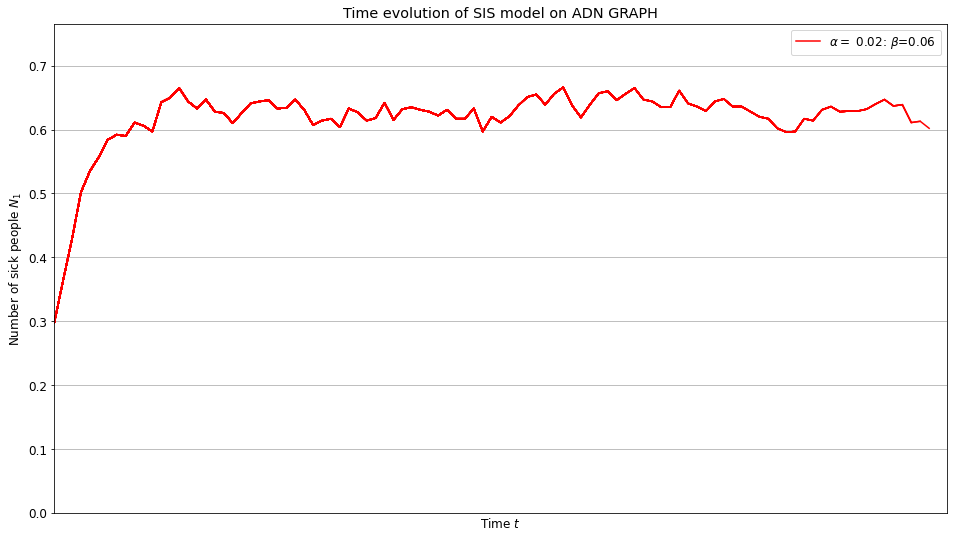

In [70]:
inf_list=np.array(infected_list[::10])/len(nodes)

# First set up the figure, labels and axes limits 
fig = plt.figure(figsize=((16,9)))
plt.ylabel('Number of sick people $N_1$')
plt.xlabel('Time $t$')
plt.title('Time evolution of SIS model on ADN GRAPH')
plt.ylim(0,np.max(inf_list)+0.1)
plt.xlim(0,len(inf_list))
plt.xticks([])
plt.grid()

# initialization function: plot the background of each frame
def init():
    plt.plot()

# animation function. This is called sequentially
def animate_plot(ii):
    plt.plot(inf_list[:ii],"r-",label=rf'$\alpha=$ {alpha}: $\beta$={beta}')
    if ii==0:
        plt.legend()
        #plt.legend(loc=(len(infected_list[0]),0.01),ncol=4,prop={'size': 8})

# call the animator. 
anim = animation.FuncAnimation(fig, animate_plot, init_func=init,frames=len(inf_list),
                                interval=100, save_count=len(inf_list))
rc('animation', html='html5')
#save animation to file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('time_evolution_hub_vaccination.mp4', writer=writer)
#anim

<module 'matplotlib.pyplot' from 'E:\\programy\\pyton\\lib\\site-packages\\matplotlib\\pyplot.py'>

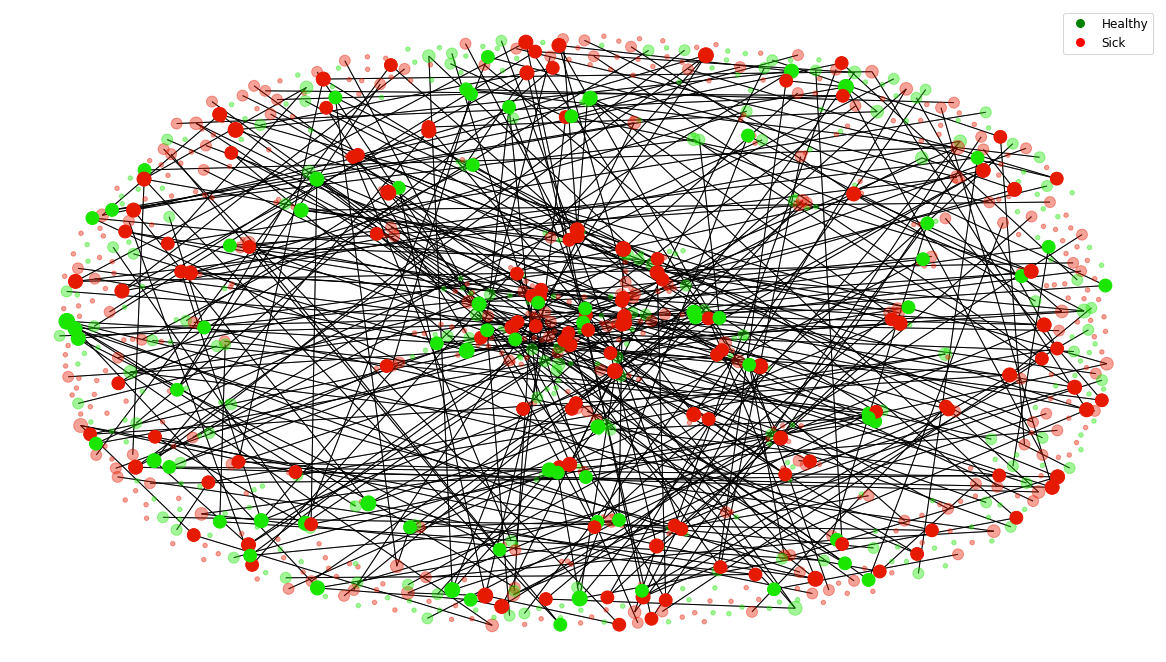

In [71]:

#create custom color map to disinguish between sick, healthy and vaccinated
pos=nx.spring_layout(G,k=0.03)
colors = [ (0.1, 0.9, 0),(0.9, 0.1, 0)]
cmap = LinearSegmentedColormap.from_list('cmap_own', colors, N=2)
plt.figure(figsize=(16,9))
plot_graph(graph_list[299],pos,cmap)


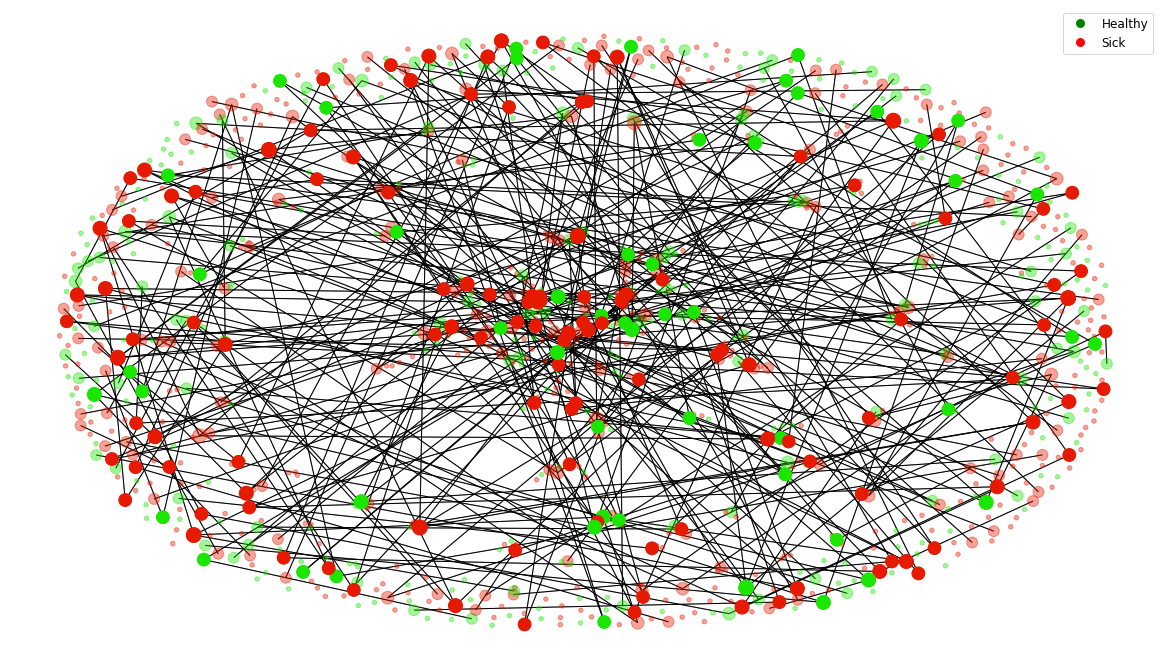

In [74]:
def init_graph():
    # First set up the figure, the axis, and the plot element we want to animate
    plt.title('Time evolution of SIS model with vaccination')
    plt.plot()

# animation function. This is called sequentially
def animate_graph(ii):
    plot_graph(graph_list[ii],pos,cmap)


# call the animator
fig = plt.figure(figsize=((16,9)))
anim = animation.FuncAnimation(fig, animate_graph, init_func=init_graph, interval=10,frames=100)
rc('animation', html='html5')
writer = FFMpegWriter(fps=5, metadata=dict(artist='Me'),  bitrate=10000)
anim.save('time_evolution_of_graph.mp4', writer=writer)

<module 'matplotlib.pyplot' from 'E:\\programy\\pyton\\lib\\site-packages\\matplotlib\\pyplot.py'>

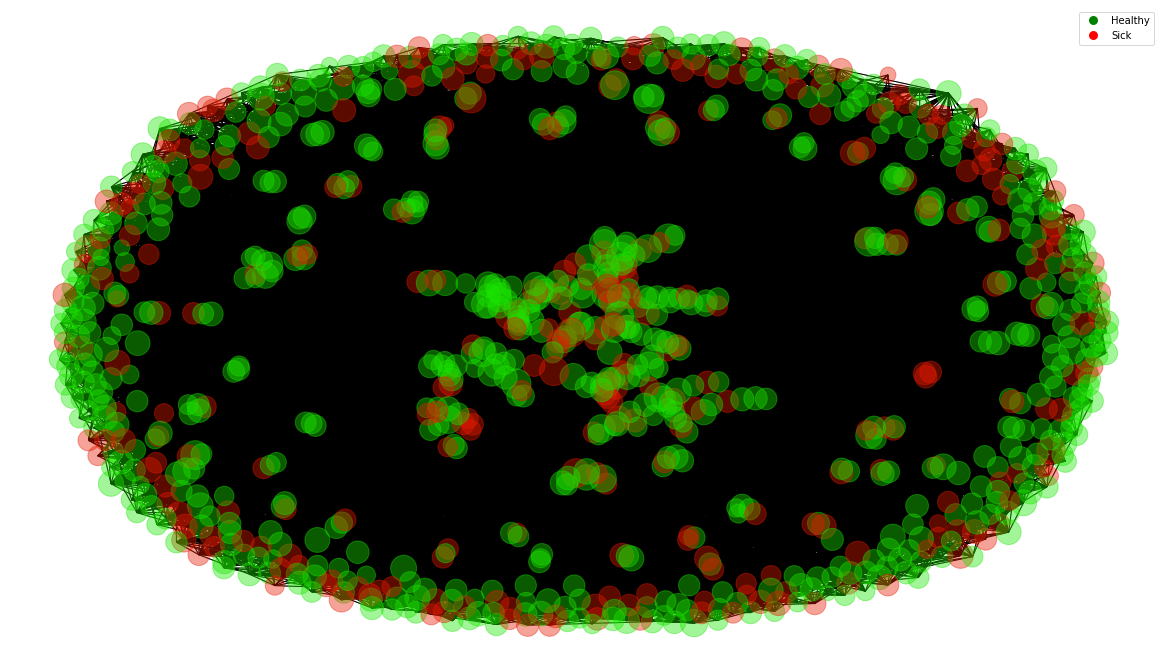

In [11]:

def integrate_graph(G,time_frames):
     H=nx.Graph()
     H.add_nodes_from(list(G.nodes()))
     for graph in graph_list[:time_frames]:
          H=nx.compose(graph,H)
     return H
fig = plt.figure(figsize=((16,9)))
H=integrate_graph(G,30)
plot_graph(H,pos,cmap)

Text(0.5, 1.0, 'Wykres dla m=2, $\\alpha$=0.02, $\\beta$=0.06')

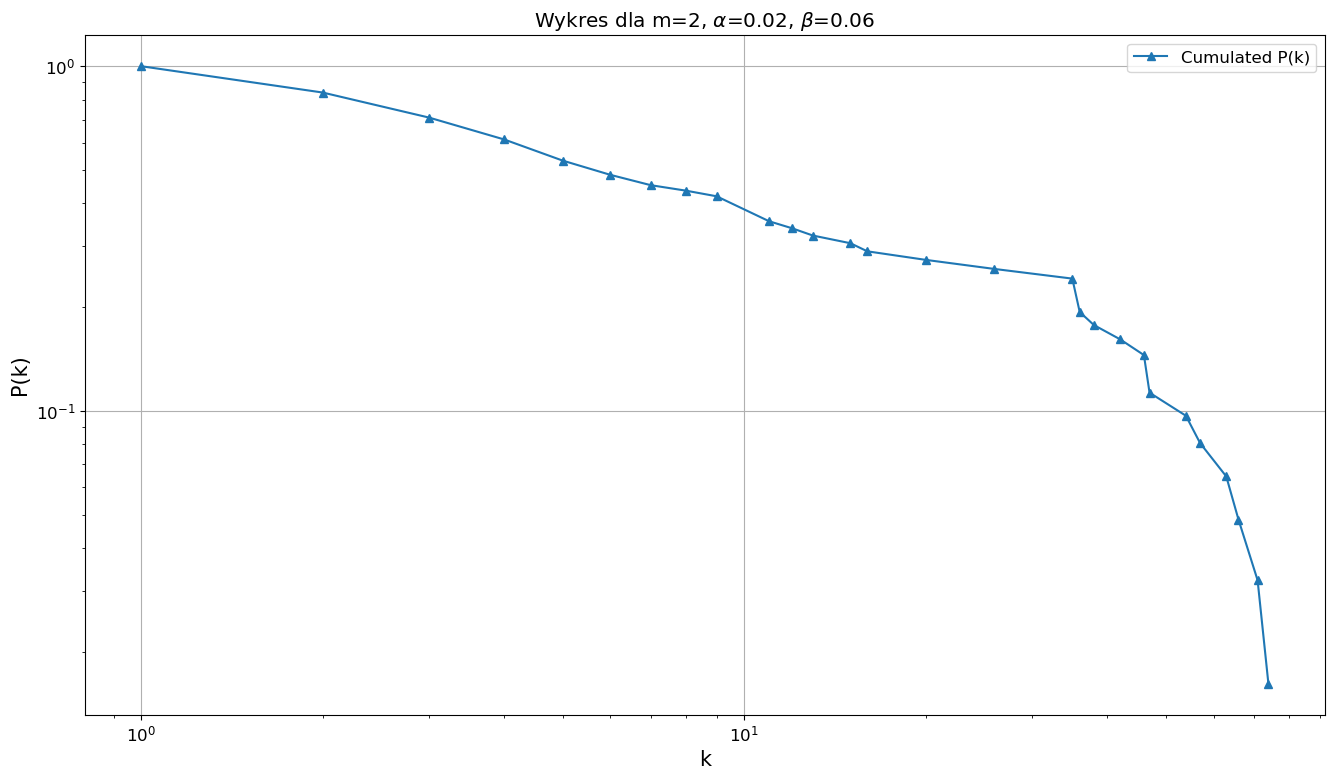

In [64]:
node_list=[v for v in dict(H.degree).values()]
vals,counts=np.unique(node_list,return_counts=True)
vals,counts=np.unique(counts,return_counts=True)

prob=counts/np.sum(counts)
cum_sum=np.cumsum(prob[::-1])[::-1]


plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,cum_sum,"^-",label="Cumulated P(k)")

logx = np.log(vals)
logy = np.log(cum_sum)
# plt.loglog(vals,prob,"o-",label="P(k)")
plt.legend()
plt.grid()
plt.xlabel("k",fontsize=15)
plt.ylabel("P(k)",fontsize=15)
beta=0.06
plt.title(rf"Wykres dla m={m}, $\alpha$={alpha}, $\beta$={beta}")

Text(0.5, 1.0, 'Wykres dla m=2, $\\gamma$=-0.75')

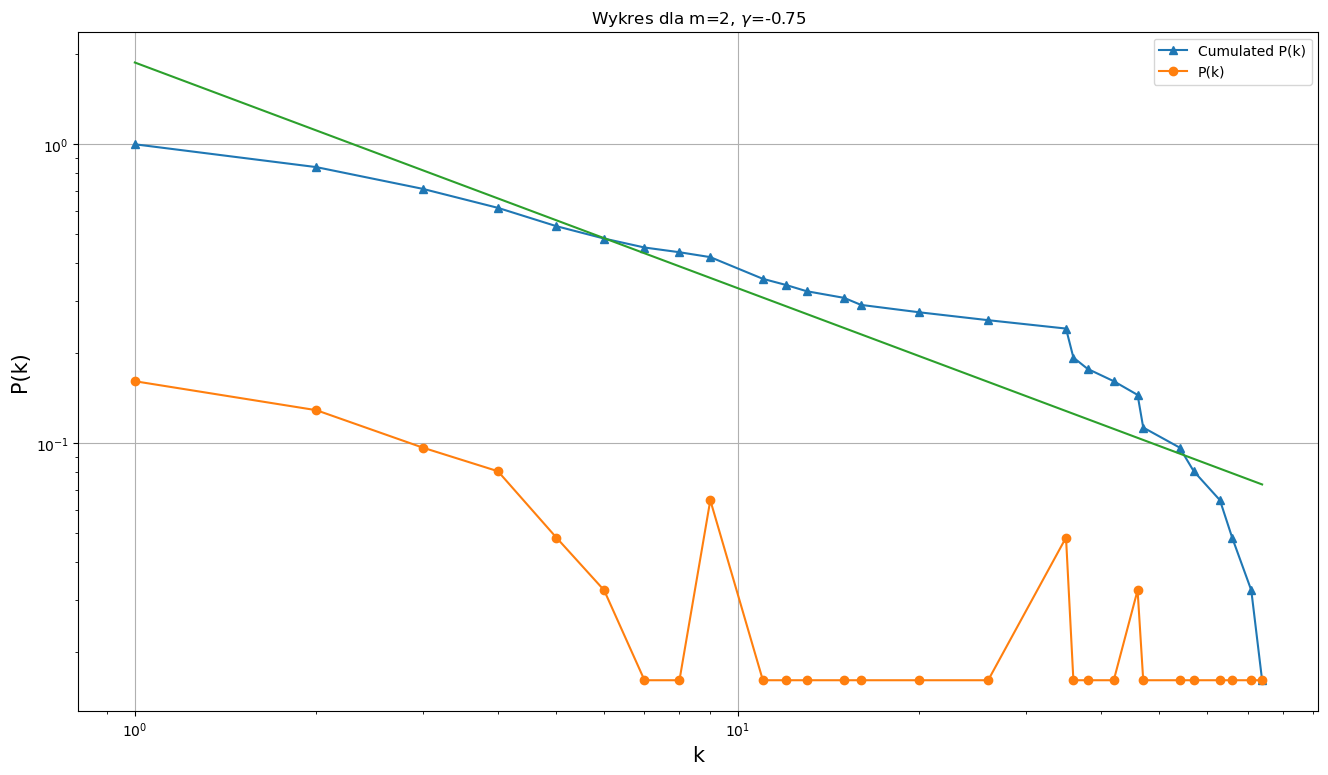

In [13]:
node_list=list(dict(H.degree).values())
vals,counts=np.unique(node_list,return_counts=True)
vals,counts=np.unique(counts,return_counts=True)

prob=counts/np.sum(counts)
cum_sum=np.cumsum(prob[::-1])[::-1]


plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,cum_sum,"^-",label="Cumulated P(k)")

logx = np.log(vals)
logy = np.log(cum_sum)
coeffs = np.polyfit(logx,logy,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))
plt.loglog(vals,prob,"o-",label="P(k)")
plt.loglog(vals,yfit(vals))
plt.legend()
plt.grid()
plt.xlabel("k",fontsize=15)
plt.ylabel("P(k)",fontsize=15)
plt.title(f"Wykres dla m={m}, $\gamma$={np.round(coeffs[0],2)}")

In [10]:
1/m*1/(np.std(activity)+np.mean(activity))

0.7516574169507279

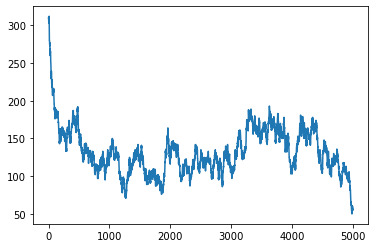

In [11]:
plt.plot(infected_list)

In [15]:

#set number of nodes and number of links created by each node
m=2
n=1000
max_iter=1000
avg_iter=10
#set prescaler which helps the network with creating connections
eta=100

In [22]:

nodes=np.arange(0,n)
#assign the activ_status to each node
activity_distribution = powerlaw.Power_Law(
    xmin=0.001,xmax=1.0, parameters=[2.8], discrete=False
)
activity= eta*activity_distribution.generate_random(n)
# betas=np.arange(0.0001,0.020,0.005).tolist()+np.arange(0.02,0.025,0.001).tolist()+np.arange(0.03,0.06,0.005).tolist()
betas=[0.001,0.005,0.008,0.01,0.012,0.014,0.015,0.018,0.019,0.020,0.021,0.022]#,0.025,0.03,0.035,0.04,0.045,0.05]
betas=np.arange(0.001,0.06,0.005)
# betas=[0.001,0.03]
# betas=[0.03]
alpha=0.02
1/m*1/(np.std(activity)+np.mean(activity))

0.8110729513129167

  0%|          | 0/12 [00:00<?, ?it/s]

[0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


  8%|▊         | 1/12 [01:20<14:48, 80.80s/it]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


 17%|█▋        | 2/12 [02:40<13:20, 80.04s/it]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


 25%|██▌       | 3/12 [03:59<11:55, 79.48s/it]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.385]
[1.385, 0.0]
[1.385, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


 33%|███▎      | 4/12 [05:27<11:05, 83.13s/it]

[1.385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[58.49]
[58.49, 69.855]
[58.49, 69.855, 87.85]
[58.49, 69.855, 87.85, 107.6]
[58.49, 69.855, 87.85, 107.6, 72.86]
[58.49, 69.855, 87.85, 107.6, 72.86, 27.305]
[58.49, 69.855, 87.85, 107.6, 72.86, 27.305, 16.555]
[58.49, 69.855, 87.85, 107.6, 72.86, 27.305, 16.555, 64.42]
[58.49, 69.855, 87.85, 107.6, 72.86, 27.305, 16.555, 64.42, 110.545]


 42%|████▏     | 5/12 [06:59<10:02, 86.07s/it]

[58.49, 69.855, 87.85, 107.6, 72.86, 27.305, 16.555, 64.42, 110.545, 88.205]
[217.415]
[217.415, 195.61]
[217.415, 195.61, 217.555]
[217.415, 195.61, 217.555, 199.63]
[217.415, 195.61, 217.555, 199.63, 219.57]
[217.415, 195.61, 217.555, 199.63, 219.57, 247.8]
[217.415, 195.61, 217.555, 199.63, 219.57, 247.8, 218.89]
[217.415, 195.61, 217.555, 199.63, 219.57, 247.8, 218.89, 220.645]
[217.415, 195.61, 217.555, 199.63, 219.57, 247.8, 218.89, 220.645, 240.795]


 50%|█████     | 6/12 [08:36<08:59, 89.86s/it]

[217.415, 195.61, 217.555, 199.63, 219.57, 247.8, 218.89, 220.645, 240.795, 221.35]
[341.785]
[341.785, 308.3]
[341.785, 308.3, 306.375]
[341.785, 308.3, 306.375, 322.36]
[341.785, 308.3, 306.375, 322.36, 315.87]
[341.785, 308.3, 306.375, 322.36, 315.87, 301.645]
[341.785, 308.3, 306.375, 322.36, 315.87, 301.645, 338.43]
[341.785, 308.3, 306.375, 322.36, 315.87, 301.645, 338.43, 323.515]
[341.785, 308.3, 306.375, 322.36, 315.87, 301.645, 338.43, 323.515, 329.945]


 58%|█████▊    | 7/12 [09:59<07:18, 87.72s/it]

[341.785, 308.3, 306.375, 322.36, 315.87, 301.645, 338.43, 323.515, 329.945, 326.805]
[406.525]
[406.525, 421.57]
[406.525, 421.57, 422.44]
[406.525, 421.57, 422.44, 404.795]
[406.525, 421.57, 422.44, 404.795, 391.995]
[406.525, 421.57, 422.44, 404.795, 391.995, 399.87]
[406.525, 421.57, 422.44, 404.795, 391.995, 399.87, 399.795]
[406.525, 421.57, 422.44, 404.795, 391.995, 399.87, 399.795, 385.565]
[406.525, 421.57, 422.44, 404.795, 391.995, 399.87, 399.795, 385.565, 404.295]


 67%|██████▋   | 8/12 [11:18<05:39, 84.82s/it]

[406.525, 421.57, 422.44, 404.795, 391.995, 399.87, 399.795, 385.565, 404.295, 421.645]
[460.905]
[460.905, 474.83]
[460.905, 474.83, 477.125]
[460.905, 474.83, 477.125, 469.05]
[460.905, 474.83, 477.125, 469.05, 476.21]
[460.905, 474.83, 477.125, 469.05, 476.21, 430.095]
[460.905, 474.83, 477.125, 469.05, 476.21, 430.095, 472.015]
[460.905, 474.83, 477.125, 469.05, 476.21, 430.095, 472.015, 471.015]
[460.905, 474.83, 477.125, 469.05, 476.21, 430.095, 472.015, 471.015, 455.615]


 75%|███████▌  | 9/12 [12:33<04:05, 81.97s/it]

[460.905, 474.83, 477.125, 469.05, 476.21, 430.095, 472.015, 471.015, 455.615, 459.665]
[508.705]
[508.705, 521.145]
[508.705, 521.145, 525.075]
[508.705, 521.145, 525.075, 551.69]
[508.705, 521.145, 525.075, 551.69, 500.56]
[508.705, 521.145, 525.075, 551.69, 500.56, 519.86]
[508.705, 521.145, 525.075, 551.69, 500.56, 519.86, 518.485]
[508.705, 521.145, 525.075, 551.69, 500.56, 519.86, 518.485, 525.21]
[508.705, 521.145, 525.075, 551.69, 500.56, 519.86, 518.485, 525.21, 507.595]


 83%|████████▎ | 10/12 [13:52<02:41, 80.79s/it]

[508.705, 521.145, 525.075, 551.69, 500.56, 519.86, 518.485, 525.21, 507.595, 511.065]
[569.295]
[569.295, 568.99]
[569.295, 568.99, 561.045]
[569.295, 568.99, 561.045, 558.22]
[569.295, 568.99, 561.045, 558.22, 564.435]
[569.295, 568.99, 561.045, 558.22, 564.435, 554.345]
[569.295, 568.99, 561.045, 558.22, 564.435, 554.345, 548.16]
[569.295, 568.99, 561.045, 558.22, 564.435, 554.345, 548.16, 564.34]
[569.295, 568.99, 561.045, 558.22, 564.435, 554.345, 548.16, 564.34, 558.1]


 92%|█████████▏| 11/12 [15:07<01:19, 79.10s/it]

[569.295, 568.99, 561.045, 558.22, 564.435, 554.345, 548.16, 564.34, 558.1, 549.99]
[593.3]
[593.3, 613.365]
[593.3, 613.365, 590.055]
[593.3, 613.365, 590.055, 606.55]
[593.3, 613.365, 590.055, 606.55, 596.43]
[593.3, 613.365, 590.055, 606.55, 596.43, 598.03]
[593.3, 613.365, 590.055, 606.55, 596.43, 598.03, 594.395]
[593.3, 613.365, 590.055, 606.55, 596.43, 598.03, 594.395, 609.035]
[593.3, 613.365, 590.055, 606.55, 596.43, 598.03, 594.395, 609.035, 607.275]


100%|██████████| 12/12 [16:24<00:00, 82.05s/it]

[593.3, 613.365, 590.055, 606.55, 596.43, 598.03, 594.395, 609.035, 607.275, 582.765]


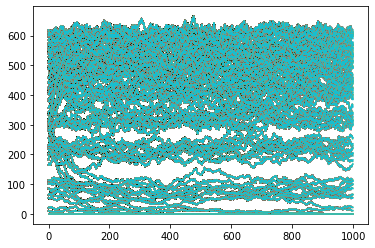

In [23]:
infected_vs_lambda=[]
for beta in tqdm(betas):
    average_steady_infected=[]
    q=0.3
    node_status=dict(zip(np.arange(0,n,1),(np.random.choice([0,1],n,p=[1-q,q]))))
    for jj in np.arange(avg_iter):
       
        #create graph with no links
        nodes=np.arange(0,n)
        G=nx.Graph()
        G.add_nodes_from(nodes)



        activity_status=dict(zip(np.arange(0,n,1),([0]*n)))
        nx.set_node_attributes(G, values=activity_status, name='activity_status')

        #set initial infected and healthy status
       
        nx.set_node_attributes(G, values=node_status, name='state')

        #list of different timeframes of network
       
        infected_list=[]
        state=node_status

        for ii in range(max_iter):
            G=nx.Graph()
            G.add_nodes_from(nodes)
            nx.set_node_attributes(G, values=activity_status, name='activity_status')
            
            #select nodes which will be active
            active_nodes=[node_id  for node_id, aa in zip(nodes,activity) if np.random.random()<=min(1,aa)]

            create_connections(G,active_nodes)
            
            state=infect_cure_node(G,state,active_nodes,alpha,beta)   
            nx.set_node_attributes(G, values=state, name='state')
            
            infected_list+=[np.sum(list(state.values()))]
            plt.plot(infected_list)
        average_steady_infected+=[np.average(infected_list[(max_iter-200):])]
        print(average_steady_infected)
    infected_vs_lambda+=[np.average(average_steady_infected)]

In [ ]:
np.std(activity)

In [ ]:
np.mean(activity)

In [43]:
1/m*1/(np.std(activity)+np.mean(activity))

0.7752083657869485

In [35]:
np.array(betas)/alpha

array([0.05, 0.3 , 0.55, 0.8 , 1.05, 1.3 , 1.55, 1.8 , 2.05, 2.3 , 2.55,
       2.8 ])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


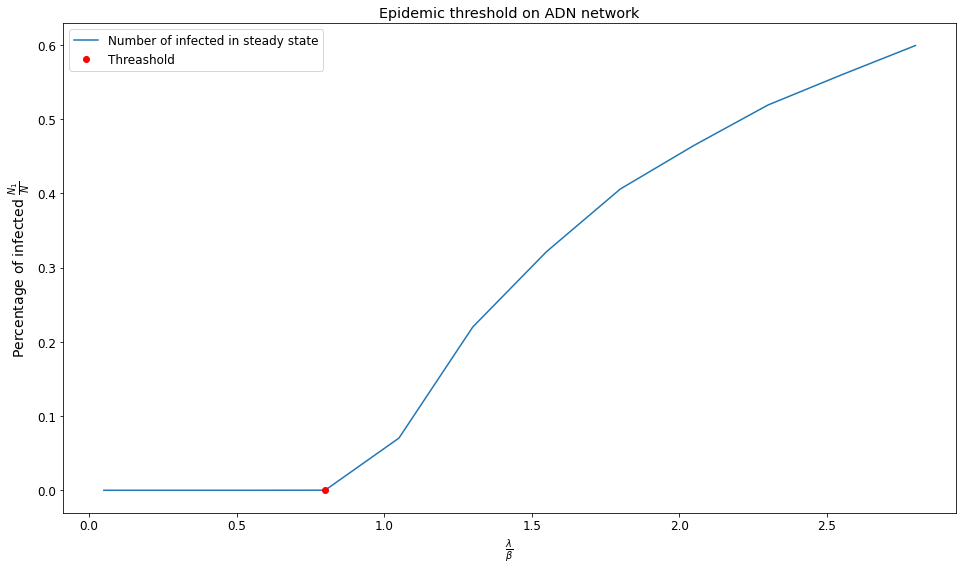

In [59]:
#dla 0.65 sredniego a wyglada na to ze dziala
#dla okolo 0.8 zajebiscie dziala pozdror
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(16,9))
plt.plot(np.array(betas)/alpha,np.array(infected_vs_lambda)/1000, label='Number of infected in steady state')
plt.xlabel(rf'$\frac{{\lambda}}{{\beta}}$',fontsize=14)
plt.ylabel(rf'Percentage of infected $\frac{{N_1}}{{N}}$',fontsize=14)
plt.plot(0.80,0,'ro',label='Threashold')
plt.title('Epidemic threshold on ADN network')
plt.legend()

In [ ]:
infected_vs_lambda